In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm
import matplotlib.pyplot as plt 



In [2]:
%%time 
adata = sc.read_h5ad("SCP1064/other/adata.h5ad")
adata.X.data

CPU times: user 2.39 s, sys: 19.6 s, total: 21.9 s
Wall time: 48.7 s


array([2., 1., 1., ..., 2., 1., 1.])

In [10]:
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=0)

In [13]:
(adata.obs["n_genes"] < 500).sum(), (adata.var["n_cells"] < 500).sum()

(304, 8376)

In [14]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=500)

In [15]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e5)
sc.pp.log1p(adata)

In [16]:
# make sure we can match sgRNAs back to the genes
adata.obs

,library_preparation_protocol,condition,MOI,sgRNA,UMI_count,sgRNAs,n_genes
NAME,,,,,,,
CELL_1,10X 3' v3 sequencing,Control,1,HLA-B_2,10832.0,HLA-B_2,3520
CELL_2,10X 3' v3 sequencing,Control,2,NaN,10731.0,"NGFR_3,SERPINF1_3",3531
CELL_3,10X 3' v3 sequencing,Control,1,HLA-B_2,28821.0,HLA-B_2,5541
CELL_4,10X 3' v3 sequencing,Control,2,NaN,15322.0,"NMRK1_3,S100A6_3",4086
CELL_5,10X 3' v3 sequencing,Control,0,NaN,10314.0,,3178
...,...,...,...,...,...,...,...
CELL_218327,10X 3' v3 sequencing,Co-culture,4,NaN,12722.0,"CTSO_3,PIK3IP1_3,VDAC2_2,WNT7A_1",3686
CELL_218328,10X 3' v3 sequencing,Co-culture,2,NaN,11643.0,"JAK2_3,SLC7A5P1_3",3462
CELL_218329,10X 3' v3 sequencing,Co-culture,3,NaN,12497.0,"S100A6_2,SAT1_2,ONE_NON-GENE_SITE_177",3768


In [17]:
# check if the field MOI has some irregularities, such that a truncated guide or a wrong number
ind = []
for index, row in tqdm(adata.obs.iterrows(), total=adata.n_obs):
    flag = False
    if row["sgRNAs"] != "":
        guides = row["sgRNAs"].split(",")
        if len(guides) != row["MOI"]:
            flag = True
        if "_" not in guides[-1]:
            flag = True
    if flag:
        ind += [index]

100%|██████████| 218027/218027 [00:10<00:00, 19918.72it/s]


In [18]:
# empty!!
ind

[]

In [19]:
# check gene sets and ensure matching with measurements
err = 0
ind = []
obs_genes = {}
unfound_genes = {}
targets = []
for index, row in tqdm(adata.obs.iterrows(), total=adata.n_obs):
    current_target = []
    if row["sgRNAs"] != "":
        # get all guides in cells
        sg = row["sgRNAs"].split(",")
        # get gene name by stripping guide specific info
        sg_genes = [guide.rsplit("_", maxsplit=1)[0] for guide in sg]
        for gene in sg_genes:
            if gene in adata.var.index:
                # gene is found
                current_target += [gene]
                if gene not in obs_genes:
                    obs_genes[gene] = 1
                else:
                    obs_genes[gene] += 1
            else:
                if gene not in unfound_genes:
                    unfound_genes[gene] = 1
                else:
                    unfound_genes[gene] += 1
    # end gene list
    targets += [",".join(current_target)]

100%|██████████| 218027/218027 [00:11<00:00, 18466.40it/s]


In [20]:
# create regimes
regimes = np.unique(targets, return_inverse=True)[1]

In [21]:
adata.obs["targets"] = targets
adata.obs["regimes"] = regimes

In [22]:
len(obs_genes.keys())

220

In [23]:
# some leftover genes I couldn't match
unfound_genes.keys()

dict_keys(['NGFR', 'SERPINF1', 'CSPG4', 'PIK3IP1', 'ONE_NON-GENE_SITE', 'NO_SITE', 'NUP50-AS1', 'IDI2-AS1', 'CXCR4', 'JMJD7', 'TYR', 'BOLA2', 'LRRC75A-AS1', 'LINC00518', 'APOD', 'A2M', 'LEF1-AS1', 'SLC7A5P1', 'SERPINA3', 'WNT7A', 'GAS5', 'IRF4', 'APOC2', 'XAGE1A', 'CCND2', 'CDH19', 'ST6GALNAC2', 'S100B', 'HLA-H', 'SNHG6'])

## step 2: comparing variability of gene expression to guide ID

In [24]:
%%time
sc.pp.highly_variable_genes(adata, layer="counts", flavor='seurat_v3', n_top_genes=3000 , span=0.2)

CPU times: user 38 s, sys: 1min 37s, total: 2min 15s
Wall time: 4min 24s


In [25]:
adata.var

,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
A1BG,34703,True,1689.0,0.189256,0.232778,1.069112
A1BG-AS1,12461,False,NaN,0.060226,0.063213,0.964280
A4GALT,1537,False,NaN,0.007233,0.007566,0.985149
AAAS,39657,False,NaN,0.213538,0.241693,0.970792
AACS,19249,False,NaN,0.094887,0.099974,0.948419
...,...,...,...,...,...,...
ZXDB,2581,False,NaN,0.011994,0.012162,0.957151
ZXDC,14586,False,NaN,0.070569,0.073387,0.947735
ZYG11B,26023,False,NaN,0.132493,0.144036,0.972143
ZYX,153542,False,NaN,1.634701,3.017341,0.954339


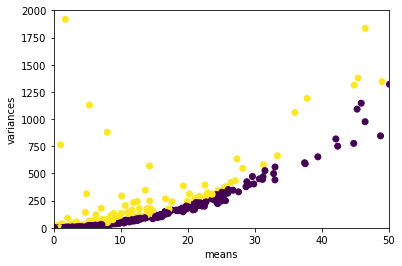

In [27]:
plt.scatter(adata.var["means"], adata.var["variances"], c=adata.var["highly_variable"])
plt.xlabel("means")
plt.ylabel("variances")
plt.xlim((0, 50))
plt.ylim((0, 2000))
plt.show()

In [28]:
presence = pd.Series(data=np.zeros_like(adata.var["means"]), index=adata.var.index)
for gene in list(obs_genes.keys()):
    presence[gene] += 1
adata.var["targeted"] = presence

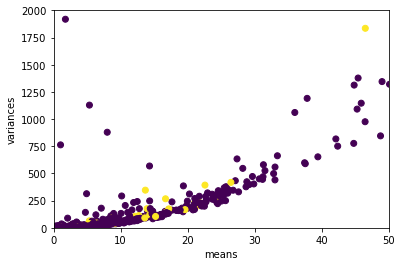

In [29]:
plt.scatter(adata.var["means"], adata.var["variances"], c=adata.var["targeted"])
plt.xlabel("means")
plt.ylabel("variances")
plt.xlim((0, 50))
plt.ylim((0, 2000))
plt.show()

In [18]:
# adata.write_h5ad("SCP1064/other/processed_adata.h5ad")

In [30]:
# out of 3000 highly variable genes, and 250 targeted genes, only 96 is in the intersection
(adata.var["highly_variable"] * adata.var["targeted"]).sum()
# for future reference we probably add all intervened genes and complete with highly variable 

100.0

In [31]:
np.unique(adata.obs.condition.values)

array(['Co-culture', 'Control', 'IFNγ'], dtype=object)

In [32]:
# filter genes (1000)
to_keep = np.logical_or(adata.var["highly_variable_rank"] < 1500, adata.var["targeted"])
adata_gf = adata[:, to_keep].copy()

In [33]:
# filter conditions
adata_gf[adata_gf.obs.condition == "Control"].copy().write_h5ad("SCP1064/ready/control/gene_filtered_adata.h5ad")
adata_gf[adata_gf.obs.condition == "Co-culture"].copy().write_h5ad("SCP1064/ready/cocult/gene_filtered_adata.h5ad")
adata_gf[adata_gf.obs.condition == "IFNγ"].copy().write_h5ad("SCP1064/ready/ifn/gene_filtered_adata.h5ad")

/home/ubuntu/anaconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'targets' as categorical
/home/ubuntu/anaconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'targets' as categorical
/home/ubuntu/anaconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a 

In [45]:
adata_small = adata_gf[np.random.choice(np.arange(adata.n_obs), size=10000, replace=False)].copy()
adata_small.write_h5ad("SCP1064/other/small_adata.h5ad")